In [1]:
# %%
import ot
import numpy as np
import otmol as otm
import pandas as pd
from openbabel import pybel
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import os
#from utils import *
# %matplotlib widget

In [ ]:
def  single_molecule_alignment(T_A, T_B, X_A, X_B, method, alpha_list):   
    C = otm.tl.cost_matrix(T_A, T_B, 1e12)
    D_A = distance_matrix(X_A, X_A)
    D_B = distance_matrix(X_B, X_B)
    rmsd_best = 1e10
        #p_best = None
    P_best = None
    alpha_best = None
    if method == 'fgw':
        # Fused Gromov-Wasserstein
        for alpha in alpha_list:
                #if D_matrix == 'euclidean':
            P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method=method, alpha=alpha)
            assignment = np.argmax(P, axis=1)
            if otm.tl.is_permutation(assignment):
                X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, otm.tl.permutation_to_matrix(assignment))
                D_ot = distance_matrix(X_A, X_B_aligned)**2
                D_ot[C > 1e10] = 1e12
                P_ot = ot.emd([], [], D_ot)
                rmsd = otm.tl.RMSD(X_A, X_B_aligned[np.argmax(P_ot, axis=1)])
                if rmsd < rmsd_best:
                    rmsd_best = rmsd
                    P_best = P_ot
                    alpha_best = alpha
    return np.argmax(P_best, axis=1)

In [2]:
def Experiment(data_path: str = None,mol_pair: list = None, method: str = 'fgw', 
               alpha_list: list = None, D_matrix: str = 'geodesic', p_list: list = None,
               setup: str = 'atom name'
               ):
    """
    Experiment with ArbAlign data.
    """
    results = []
    # Load the molecule pairs from the specified file
    for nameA, nameB in mol_pair:
        if setup == 'atom name':
            molA = next(pybel.readfile('xyz', os.path.join(data_path, nameA + '.xyz')))
            molB = next(pybel.readfile('xyz', os.path.join(data_path, nameB + '.xyz')))
            # Basic processing of the molecules
            X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
            X_B, T_B, B_B = otm.tl.process_molecule(molB)
        # Compute the distance matrices
            #D_A = otm.tl.geodesic_distance(X_A, B_A)
            #D_B = otm.tl.geodesic_distance(X_B, B_B)
        if setup == 'atom type':
            X_A, T_A = otm.tl.parse_sy2(os.path.join(data_path, nameA + '.sy2'))
            X_B, T_B = otm.tl.parse_sy2(os.path.join(data_path, nameB + '.sy2'))
            
        if setup == 'atom connectivity':
            molA = next(pybel.readfile('xyz', os.path.join(data_path, nameA + '.xyz')))
            molB = next(pybel.readfile('xyz', os.path.join(data_path, nameB + '.xyz')))
            X_A, _, _ = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
            X_B, _, _ = otm.tl.process_molecule(molB)
            T_A = otm.tl.parse_mna(os.path.join(data_path, nameA + '.mna'))
            T_B = otm.tl.parse_mna(os.path.join(data_path, nameB + '.mna'))
        C = otm.tl.cost_matrix(T_A, T_B, 1e12)
        D_A = distance_matrix(X_A, X_A)
        D_B = distance_matrix(X_B, X_B)
        rmsd_best = 1e10
        #p_best = None
        P_best = None
        alpha_best = None
        if method == 'fgw':
        # Fused Gromov-Wasserstein
            for alpha in alpha_list:
                #if D_matrix == 'euclidean':
                P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method=method, alpha=alpha)
                assignment = np.argmax(P, axis=1)
                if otm.tl.is_permutation(assignment):
                    X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, otm.tl.permutation_to_matrix(assignment))
                    D_ot = distance_matrix(X_A, X_B_aligned)**2
                    D_ot[C > 1e10] = 1e12
                    P_ot = ot.emd([], [], D_ot)
                    rmsd = otm.tl.RMSD(X_A, X_B_aligned[np.argmax(P_ot, axis=1)])
                    if rmsd < rmsd_best:
                        rmsd_best = rmsd
                        P_best = P_ot
                        alpha_best = alpha
            optimal_assignment = np.argmax(P_best, axis=1)
            
        if not otm.tl.is_permutation(optimal_assignment): # check if the assignment is 1 to 1
            print(nameA, nameB, 'Warning: the assignment is not 1 to 1')
        if otm.tl.compare_labels(T_A, T_B[optimal_assignment]): # check if atom names are matched
            print(nameA, nameB, 'Warning: unmatched {} exists'.format(setup))
        results.append({
            'nameA': nameA,
            'nameB': nameB,
            'RMSD(otmol+{})'.format(setup): rmsd_best,
            '# atoms': X_A.shape[0],
            'alpha': alpha_best,
            'assignment': optimal_assignment,
        }) 
        print(nameA, nameB, rmsd_best)

    return pd.DataFrame(results)

In [3]:
data_path = "./DataArbAlign/FGG-Tripeptide/"
mol_pair_list_path = os.path.join(data_path, 'list')
molecule_pairs = otm.tl.parse_molecule_pairs(mol_pair_list_path, mol_type='FGG')

In [4]:
otmol_name_res = Experiment(data_path, molecule_pairs, setup='atom name', method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,100))
otmol_type_res = Experiment(data_path, molecule_pairs, setup='atom type', method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,100))
otmol_conn_res = Experiment(data_path, molecule_pairs, setup='atom connectivity', method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,100))

252_FGG55 253_FGG99 1.745198868365485
252_FGG55 254_FGG300 1.9294071366041436
252_FGG55 255_FGG252 1.932128176677413
252_FGG55 256_FGG366 2.196572231253867
252_FGG55 257_FGG215 1.4228244089343798
252_FGG55 258_FGG224 0.7462840440918397
252_FGG55 259_FGG380 1.2754148103268517
252_FGG55 260_FGG412 1.6769035753978936
252_FGG55 261_FGG444 1.1422673356214295
252_FGG55 262_FGG470 1.309787418436435
252_FGG55 263_FGG80 1.4939458407745705
252_FGG55 264_FGG114 1.5740492356395144
252_FGG55 265_FGG357 1.5514850789717372
252_FGG55 266_FGG691 1.9778788068553832
252_FGG55 253_FGG99 1.8077414825992106
252_FGG55 254_FGG300 1.9781242697653947
252_FGG55 255_FGG252 2.0492639811651014
252_FGG55 256_FGG366 2.2743630825763113
252_FGG55 257_FGG215 1.4653443627965757
252_FGG55 258_FGG224 0.7462840440918397
252_FGG55 259_FGG380 1.3224685098464504
252_FGG55 260_FGG412 1.6825183948497655
252_FGG55 261_FGG444 1.1422673356214295
252_FGG55 262_FGG470 1.2827964468122988
252_FGG55 263_FGG80 1.5145040305145006
252_FGG5

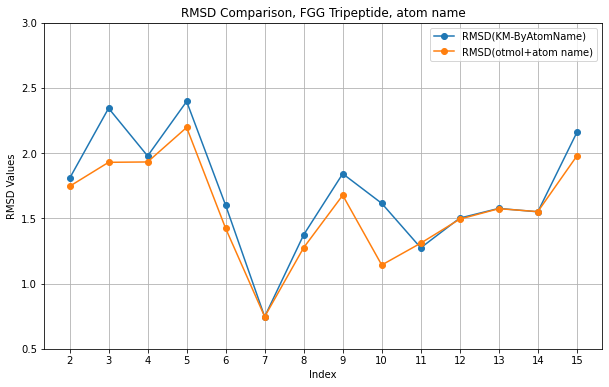

In [5]:
# Concatenate otmol_res and df along the columns
arbalign_res = pd.read_csv(os.path.join(data_path, 'rmsd-2017.dat'), sep='\s+')
combined_df = pd.concat([arbalign_res, otmol_name_res, otmol_type_res, otmol_conn_res], axis=1)
# Plot the specified columns against the Index column
columns_to_plot = ["RMSD(KM-ByAtomName)", "RMSD(otmol+atom name)"]
#"RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", 
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(range(2,16), combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison, FGG Tripeptide, atom name")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
plt.ylim(0.5, 3)
plt.xticks(range(2,16))
plt.legend()
plt.grid(True)

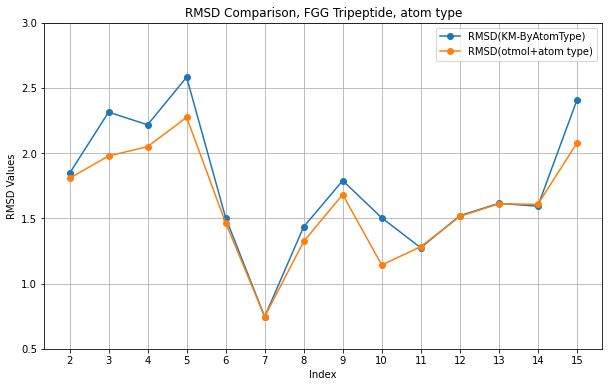

In [6]:
columns_to_plot = ["RMSD(KM-ByAtomType)", "RMSD(otmol+atom type)"]
#"RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", 
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(range(2,16), combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison, FGG Tripeptide, atom type")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
plt.ylim(0.5, 3)
plt.xticks(range(2,16))
plt.legend()
plt.grid(True)

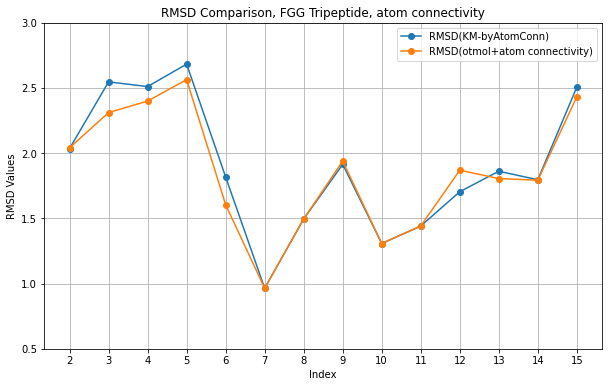

In [7]:
columns_to_plot = ["RMSD(KM-byAtomConn)", "RMSD(otmol+atom connectivity)"]
#"RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", 
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(range(2,16), combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison, FGG Tripeptide, atom connectivity")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
plt.ylim(0.5, 3)
plt.xticks(range(2,16))
plt.legend()
plt.grid(True)

In [8]:
"""
data_path = "./DataArbAlign/S1-MA-W1"
#data_path = "./DataArbAlign/FGG"
mol_pair_list_path = os.path.join(data_path, 'list')
molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='S1')
Experiment(molecule_pairs, method='fgw', alpha=0.4)"
"""

'\ndata_path = "./DataArbAlign/S1-MA-W1"\n#data_path = "./DataArbAlign/FGG"\nmol_pair_list_path = os.path.join(data_path, \'list\')\nmolecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type=\'S1\')\nExperiment(molecule_pairs, method=\'fgw\', alpha=0.4)"\n'

In [9]:
# %%
# Read the molecules
molA = next(pybel.readfile("xyz", "./DataArbAlign/FGG-Tripeptide/252_FGG55.xyz"))
molB = next(pybel.readfile("xyz", "./DataArbAlign/FGG-Tripeptide/253_FGG99.xyz"))
#molA = next(pybel.readfile("xyz", "./DataArbAlign/S1-MA-W1/s1maw1-1.xyz"))

1.725024707131574
['O' 'C' 'O' 'H' 'C' 'H' 'H' 'N' 'H' 'C' 'O' 'C' 'H' 'H' 'N' 'H' 'C' 'O'
 'C' 'N' 'H' 'H' 'H' 'C' 'H' 'H' 'C' 'C' 'H' 'C' 'H' 'C' 'H' 'C' 'H' 'C'
 'H']
['O' 'C' 'O' 'H' 'C' 'H' 'H' 'N' 'H' 'C' 'O' 'C' 'H' 'H' 'N' 'H' 'C' 'O'
 'C' 'N' 'H' 'H' 'H' 'C' 'H' 'H' 'C' 'C' 'H' 'C' 'H' 'C' 'H' 'C' 'H' 'C'
 'H']
[]


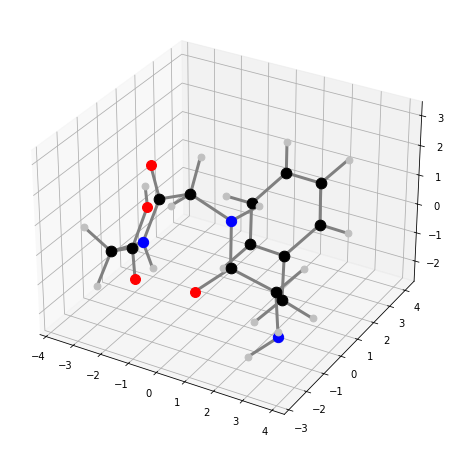

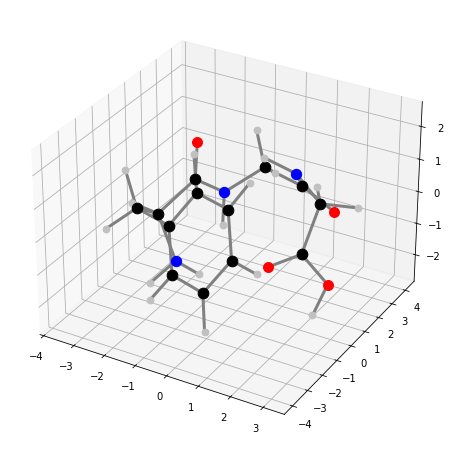

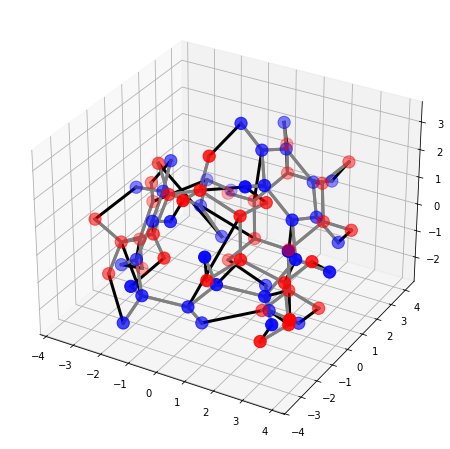

In [11]:
# %%
def permutation_to_matrix(permutation):
    """
    Converts a permutation list to a permutation matrix.
    
    Args:
        permutation (list or array): A list or array representing the permutation.
                                     For example, [2, 0, 1] means index 0 maps to 2, index 1 maps to 0, etc.
    
    Returns:
        numpy.ndarray: A permutation matrix.
    """
    n = len(permutation)
    matrix = np.zeros((n, n), dtype=int)
    for i, j in enumerate(permutation):
        matrix[i, j] = 1
    return matrix
# Basic processing of the molecules
X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
X_B, T_B, B_B = otm.tl.process_molecule(molB)
otm.pl.plot_molecule(X_A, T_A, B_A, coloring = 'type', sizing = 'type')
otm.pl.plot_molecule(X_B, T_B, B_B, coloring = 'type', sizing = 'type')
P = permutation_to_matrix(otmol_name_res['assignment'][0])
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P) 
print(otm.tl.RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(T_A)
print(T_B[np.argmax(P, axis=1)])
print(otm.tl.compare_labels(T_A, T_B[np.argmax(P, axis=1)]))
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P, weight_cutoff=0.01)
plt.show()


In [ ]:
# %%
C = otm.tl.molecule_physchem_distance(T_A, T_B)
D_A = otm.tl.geodesic_distance(X_A, B_A)
D_B = otm.tl.geodesic_distance(X_B, B_B)

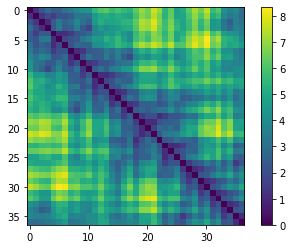

In [ ]:
# %%
# Fused Gromov-Wasserstein
DD_A = distance_matrix(X_A, X_A)
DD_B = distance_matrix(X_B, X_B)
P = otm.tl.molecule_optimal_transport(C, D_A+17*DD_A, D_B+17*DD_B, method='fgw', alpha=0.1)
plt.show()
plt.imshow(DD_A)
plt.colorbar()

2.4043992558309104
[(0, 'O', 'H'), (5, 'H', 'O'), (8, 'H', 'C'), (9, 'C', 'H'), (14, 'N', 'C'), (17, 'O', 'N'), (18, 'C', 'H'), (19, 'N', 'C'), (23, 'C', 'N'), (25, 'H', 'O')]


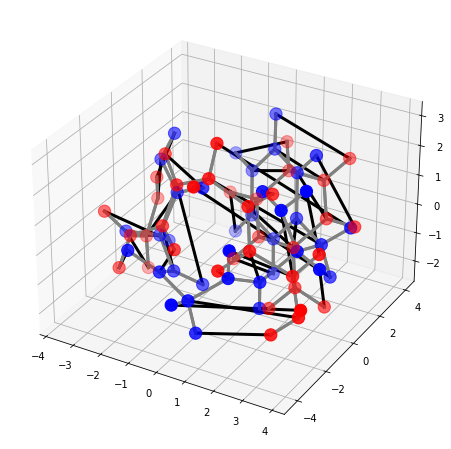

In [ ]:
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P) 
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P, weight_cutoff=0.01)
plt.show()

2.237235753083236


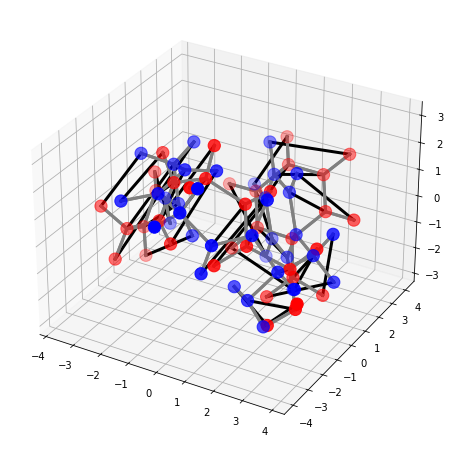

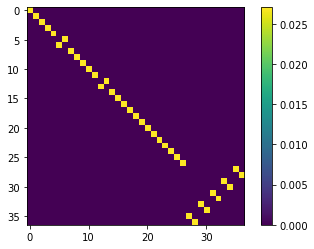

In [ ]:
# %%
# Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='gw', alpha=0.9)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()


No more edges in the graph.
2.1552160380660763


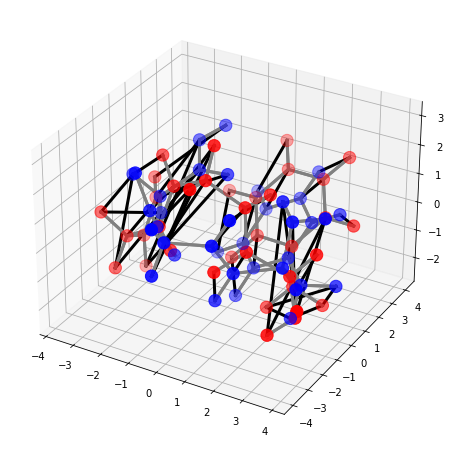

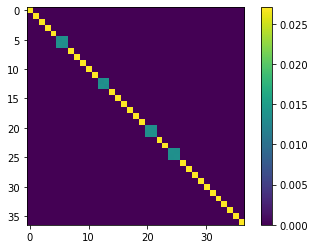

In [ ]:
# %%
# Supervised Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='sgw', sgw_cutoff=5)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()

# of potential non-zeros in P: 210
2.1552260859951216
[]


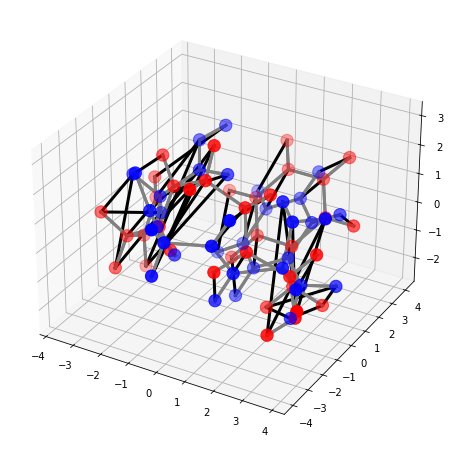

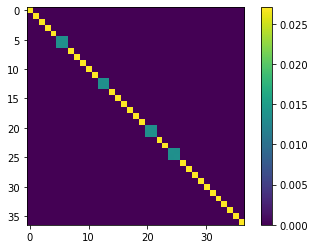

In [ ]:
# %%
# Fused supervised Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='fsgw', sgw_cutoff=5, alpha=0.5)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()